In [3]:
#### from PIL import Image
import numpy as np
#img=Image.open('ORL/s1/res8.png')
#img.show()
import re
from matplotlib import pyplot as plt
import numpy
M1=32
M2=6
M3=10
def read_pgm(filename, byteorder='>'):
    """Return image data from a raw PGM file as numpy array.

    Format specification: http://netpbm.sourceforge.net/doc/pgm.html

    """
    with open(filename, 'rb') as f:
        buffer = f.read()
    try:
        header, width, height, maxval = re.search(
            b"(^P5\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    except AttributeError:
        raise ValueError("Not a raw PGM file: '%s'" % filename)
    return numpy.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))


if __name__ == "__main__":
    database=[]
    X=[]
    for i in range(32):
        temp=[]
        for j in range(6):
            image = read_pgm("../images/ORL/s"+str(i+1)+"/"+str(j+1)+".pgm", byteorder='<')
            temp.append(image)
            X.append(image.ravel())
        database.append(temp)
    database=np.array(database)
    X=np.array(X)
    Xb=np.sum(X,axis=0)
    Xb=Xb/X.shape[0]
    Xib=np.subtract(X,Xb)
    L=np.matmul(Xib,Xib.T)
    print(L.shape)
    print(X.shape,X.shape[0])
    print(Xib.shape)
    #image = read_pgm("ORL/s1/1.pgm", byteorder='<')
    #print(type(image))
    #plt.imshow(database[31][1], pyplot.cm.gray)

(192, 192)
(192, 10304) 192
(192, 10304)


In [5]:
import sys
from numpy import linalg as LA
def eigcof(U,k,Xb,zp):
    Zpb=np.subtract(zp,Xb)
    vkb=U[:,:k]
    #print(vkb.shape,Zpb.shape)
    return np.matmul(np.transpose(vkb),Zpb)
def diff(alphas,u,K,Xb,image):
    a,b,c=alphas.shape
    mins=[sys.maxsize,0,0]
    vec=eigcof(u,K,Xb,image.ravel())
    #print(vec)
    c=0
    for i in range(a):
        for j in range(b):
            #print(vec.shape,alphas[i,j].shape)
            res=np.subtract(vec,alphas[i,j])
            val=LA.norm(res)
            #print(vec,alphas[i,j],val)
            c=1
            if(val<mins[0]):
                #print(vec,alphas[i,j],val,i,j)
                mins=[val,i,j]
    return mins[1]+1#[mins[1]+1,mins[2]+1]
def onestep(Alphas,u,K,Xb):
    Tot=0
    Pos=0
    for i in range(32):
        for j in range(6,10):
            image = read_pgm("../images/ORL/s"+str(i+1)+"/"+str(j+1)+".pgm", byteorder='<')
            chk=diff(Alphas,u,K,Xb,image.ravel())
            if(chk==(i+1)):
                Pos+=1
            Tot+=1
    return Pos/Tot
def Aplcal(u,K,Xb):
    Alphas=[]
    for i in range(32):
        temp=[]
        for j in range(6):
            image = read_pgm("../images/ORL/s"+str(i+1)+"/"+str(j+1)+".pgm", byteorder='<')
            temp.append(eigcof(u,K,Xb,image.ravel()))
        Alphas.append(temp)
    Alphas=np.array(Alphas)
    return Alphas
        

In [6]:
w, v = LA.eig(L)
print(Xib.shape,v.shape)
U=np.matmul(Xib.T,v)
#U=U / np.linalg.norm(U)
U = (U-U.min(axis=0))/(U.max(axis=0)-U.min(axis=0))
print(U.shape)
u=U

(192, 10304) (192, 192)
(10304, 192)


U is the eigen vector matrix of Covariance matrix with shape(10304x192).

In [7]:
image = read_pgm("../images/ORL/s"+str(1)+"/"+str(7)+".pgm", byteorder='<')
print(eigcof(u,3,Xb,image.ravel()).shape)
K=20
Alphas=[]
for i in range(32):
        temp=[]
        for j in range(6):
            image = read_pgm("../images/ORL/s"+str(i+1)+"/"+str(j+1)+".pgm", byteorder='<')
            temp.append(eigcof(u,K,Xb,image.ravel()))
        Alphas.append(temp)
Alphas=np.array(Alphas)

(3,)


In [9]:
#print(Alphas)
image = read_pgm("../images/ORL/s"+str(11)+"/"+str(8)+".pgm", byteorder='<')
print(diff(Alphas,u,K,Xb,image.ravel()))
Tot=0
Pos=0
for i in range(32):
        temp=[]
        for j in range(6,10):
            image = read_pgm("../images/ORL/s"+str(i+1)+"/"+str(j+1)+".pgm", byteorder='<')
            chk=diff(Alphas,u,K,Xb,image.ravel())
            if(chk==(i+1)):
                Pos+=1
            Tot+=1
print(Pos,Tot,'over')

11
94 128 over


In [10]:
Kval=[1, 2, 3, 5, 10, 15, 20, 30, 50, 75, 100,150,170]
x1=Kval.copy()
y1=[]
for kv in Kval:
    y1.append(onestep(Aplcal(u,kv,Xb),u,kv,Xb))
print(x1)
print(y1)
    

[1, 2, 3, 5, 10, 15, 20, 30, 50, 75, 100, 150, 170]
[0.15625, 0.3828125, 0.5703125, 0.6484375, 0.7265625, 0.7421875, 0.734375, 0.6953125, 0.6171875, 0.578125, 0.546875, 0.5, 0.46875]


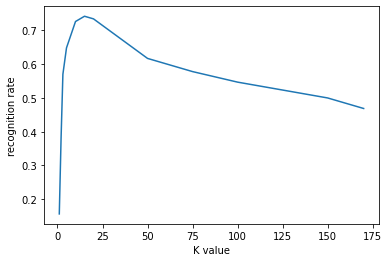

In [11]:
plt.plot(x1,y1)
plt.xlabel('K value')
plt.ylabel('recognition rate')
plt.savefig('orleig')
plt.show()

The above graph shows recognition rate vs k for 0 to 175 we got best k value near 20-25.

In [12]:
#Xib=np.transpose(Xib)
print(Xib.shape)
u, s, vh = np.linalg.svd(Xib, full_matrices=False)
print(u.shape,s.shape,vh.shape)
#print(s)

(192, 10304)
(192, 192) (192,) (192, 10304)


In [14]:
#Yale
def readpgm(filename, byteorder='>'):
    """Return image data from a raw PGM file as numpy array.
    Format specification: http://netpbm.sourceforge.net/doc/pgm.html
    """
    with open(filename, 'rb') as f:
        buffer_ = f.read()
    try:
        header, width, height, maxval = re.search(
            b"(^P5\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer_).groups()
    except AttributeError:
        raise ValueError("Not a raw PGM file: '%s'" % filename)
    try:
        res= np.frombuffer(buffer_,
                         dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                         count=int(width)*int(height),
                         offset=len(header)
                         ).reshape((int(height), int(width)))
    except ValueError as e:
        return []
        
    return res
import os
from collections import defaultdict
traindic=defaultdict(lambda:[])
testdic=defaultdict(lambda:[])

path = '../images/CroppedYale'

folders = []
nX=[]
# r=root, d=directories, f = files
for r,d, f in os.walk(path):
    for fol in d:
        #if '.txt' in file:
            folders.append(os.path.join(r, fol))
for i in folders:
    ke=int(i[-2:])
    c=0
    for r,d, f in os.walk(i):
        for file in f:
            if c<40:
                #print(os.path.join(r, file))
                image = readpgm(os.path.join(r, file))
                if(image!=[]):
                    traindic[ke].append(image.ravel())
                    nX.append(image.ravel())
            else:
                image = readpgm(os.path.join(r, file))
                if(image!=[]):
                    testdic[ke].append(image.ravel())
            if(image!=[]):
                c+=1
                
#print(traindic[1][0].shape)
nX=np.array(nX)
nXb=np.sum(nX,axis=0)
nXb=nXb/nX.shape[0]
nXib=np.subtract(nX,nXb)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


In [15]:
print(nXib.shape)
nXib1=np.transpose(nXib)
print(nXib1.shape)
u, s, vh = np.linalg.svd(nXib1, full_matrices=False)
print(u.shape,s.shape,vh.shape)

(1520, 32256)
(32256, 1520)
(32256, 1520) (1520,) (1520, 1520)


In [16]:
print(nX.shape)

(1520, 32256)


In [17]:
#functions
import sys
from numpy import linalg as LA
def eigcof2(U,k,Xb,zp,th=0):
    Zpb=np.subtract(zp,Xb)
    if(th==0):
        vkb=U[:,:k]
    if(th==1):
        vkb=U[:,3:k]
    #print(vkb.shape,Zpb.shape)
    return np.matmul(np.transpose(vkb),Zpb)
def diff2(alphas,u,K,Xb,image,th=0):
    mins=[sys.maxsize,0]
    vec=eigcof2(u,K,Xb,image,th)
    for i in alphas.keys():
        for j in alphas[i]:
            res=np.subtract(vec,j)
            val=LA.norm(res)
            if(val<mins[0]):
                mins=[val,i]
    
            
    return mins[1]#[mins[1]+1,mins[2]+1]
def onestep2(Alphas,u,K,Xb,th=0):
    Tot=0
    Pos=0
    for i in testdic.keys():
        for j in testdic[i]:
            chk=diff2(Alphas,u,K,Xb,j,th)
            if(chk==i):
                Pos+=1
            Tot+=1
    return Pos/Tot
def Aplcal2(u,K,Xb,th=0):
    Alphas=defaultdict(lambda:[])
    for i in traindic.keys():
        for j in traindic[i]:
            Alphas[i].append(eigcof2(u,K,Xb,j,th))
    return Alphas
        

In [18]:
Kval=[5, 10, 15, 20, 30, 50, 60, 65, 75, 100, 200, 300, 500, 1000]
x1=Kval.copy()
y1=[]
for kv in Kval:
    print('kval',kv)
    y1.append(onestep2(Aplcal2(u,kv,nXb,th=1),u,kv,nXb,th=1))
print(x1)
print(y1)

kval 5
kval 10
kval 15
kval 20
kval 30
kval 50
kval 60
kval 65
kval 75
kval 100
kval 200
kval 300
kval 500
kval 1000
[5, 10, 15, 20, 30, 50, 60, 65, 75, 100, 200, 300, 500, 1000]
[0.11573033707865168, 0.35842696629213483, 0.48764044943820223, 0.550561797752809, 0.6314606741573033, 0.6955056179775281, 0.7067415730337079, 0.7123595505617978, 0.7168539325842697, 0.7303370786516854, 0.7528089887640449, 0.7584269662921348, 0.7640449438202247, 0.7674157303370787]


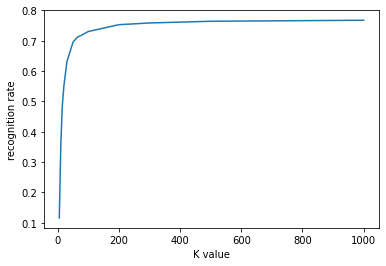

In [19]:
plt.plot(x1,y1)
plt.xlabel('K value')
plt.ylabel('recognition rate')
plt.savefig('yalesvg3less')
plt.show()

We got the k value increasing as more and more ks are considered and a reasonable k will be 400 because beyond that we are not having much accuracy.
